C:\Users\imran\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\imran\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<Figure size 600x500 with 0 Axes>

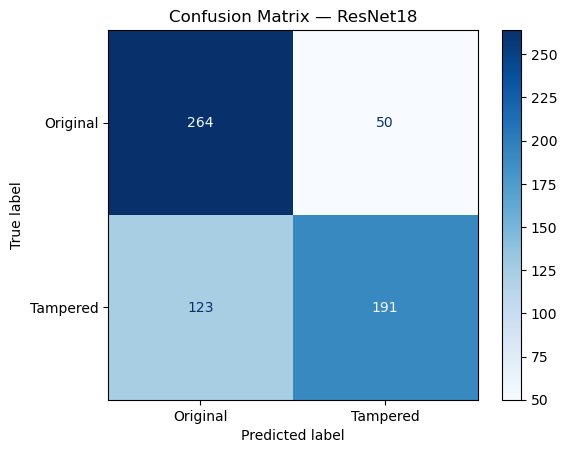


 Classification Report:

              precision    recall  f1-score   support

    Original       0.68      0.84      0.75       314
    Tampered       0.79      0.61      0.69       314

    accuracy                           0.72       628
   macro avg       0.74      0.72      0.72       628
weighted avg       0.74      0.72      0.72       628



In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Defining the model again

class ResNetBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=False)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.base_model(x).squeeze()


# Load trained model

model = ResNetBinaryClassifier()
model.load_state_dict(torch.load("resnet_tampered_patch_classifier.pth", map_location=torch.device('cpu')))
model.eval()


# Load validation dataset

val_dir = r"C:\Users\imran\OneDrive\Robotics Projects\Image Forgery\Image Data\VALIDATION_CG-1050\VALIDATION"
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Generate predictions

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        preds = (outputs > 0.5).int()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())


# Confusion Matrix & Report

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Original", "Tampered"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix — ResNet18")
plt.show()

# Print classification report
print("\n Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["Original", "Tampered"]))
